In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
df0 = pd.read_csv(r"sp500_closefull.csv", index_col=0, parse_dates=True)
df0.dropna(axis=0, how='all', inplace=True) # drop any rows with missing values
df0.dropna(axis=1, how='any', inplace=True) # drop any cols with at least 1 missing value (we don't wat forward7back fillin)
df0.head()

,CSCO,UAL,TROW,ISRG,PRGO,TPR,DVN,MRO,BA,VRTX,...,M,CRM,PGR,WAT,BWA,LRCX,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,24.690001,12.80,54.400002,102.923332,40.349998,36.310001,76.570000,19.153616,56.180000,44.240002,...,17.059999,18.705000,18.030001,61.630001,16.889999,39.880001,15.20,3.51000,238.580002,30.242558
2010-01-05,24.580000,13.91,55.009998,102.459999,38.790001,36.750000,76.650002,19.171511,58.020000,42.779999,...,16.860001,18.625000,17.969999,60.790001,17.695000,39.610001,15.11,3.61500,239.610001,29.851370
2010-01-06,24.420000,13.27,54.150002,103.946663,38.299999,37.470001,76.419998,19.595024,59.779999,42.029999,...,17.100000,18.592501,17.790001,60.900002,18.344999,39.430000,15.38,3.69500,234.669998,29.916569
2010-01-07,24.530001,13.55,54.110001,103.556664,37.990002,37.490002,75.970001,19.475725,62.200001,41.500000,...,17.490000,18.510000,17.549999,61.160000,18.594999,39.360001,15.82,3.65125,237.250000,29.627834
2010-01-08,24.660000,13.33,53.900002,102.986664,37.779999,37.270000,76.120003,19.505550,61.599998,40.669998,...,16.920000,18.537500,17.709999,61.209999,18.254999,40.349998,15.77,3.64375,238.919998,29.534695


In [3]:
# new df containing all log returns of SP components

df_returns = pd.DataFrame()
for name in df0.columns:
    df_returns[name] = np.log(df0[name]).diff()
    
df_returns.head()

,CSCO,UAL,TROW,ISRG,PRGO,TPR,DVN,MRO,BA,VRTX,...,M,CRM,PGR,WAT,BWA,LRCX,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,-0.004465,0.083163,0.011151,-0.004512,-0.039429,0.012045,0.001044,0.000934,0.032227,-0.033559,...,-0.011793,-0.004286,-0.003333,-0.013723,0.046560,-0.006793,-0.005939,0.029476,0.004308,-0.013019
2010-01-06,-0.006531,-0.047102,-0.015757,0.014405,-0.012713,0.019402,-0.003005,0.021850,0.029883,-0.017687,...,0.014134,-0.001746,-0.010067,0.001808,0.036075,-0.004555,0.017711,0.021889,-0.020832,0.002182
2010-01-07,0.004494,0.020881,-0.000739,-0.003759,-0.008127,0.000534,-0.005906,-0.006107,0.039684,-0.012690,...,0.022551,-0.004447,-0.013583,0.004260,0.013536,-0.001777,0.028207,-0.011911,0.010934,-0.009698
2010-01-08,0.005286,-0.016369,-0.003889,-0.005519,-0.005543,-0.005886,0.001973,0.001530,-0.009693,-0.020203,...,-0.033133,0.001485,0.009075,0.000817,-0.018454,0.024841,-0.003166,-0.002056,0.007014,-0.003149


In [4]:
# split into train and test
Ntest = 1000
train_data = df_returns.iloc[:-Ntest]
test_data = df_returns.iloc[-Ntest:]

feats = ['AAPL', 'MSFT', 'AMZN'] # input features

In [5]:
# Env Class
class Env:
    def __init__(self, df): # Constructor taking df
        self.df = df # set df to an instant variable
        self.n = len(df)
        self.current_idx = 0
        self.action_space = [0, 1, 2] # BUY, SELL, HOLD
        self.invested = 0

        self.states = self.df[feats].to_numpy()
        self.rewards = self.df['SPY'].to_numpy()
        #self.total_buy_and_hold = 0

    def reset(self):
        self.current_idx = 0
        #self.invested = 0
        #self.total_buy_and_hold = 0
        return self.states[self.current_idx] # return initial state

    def step(self, action):
        # need to return (next_state, reward, done)
        self.current_idx += 1
        if self.current_idx >= self.n:
            raise Exception("Exception already done")

        if action == 0: # BUY
            self.invested = 1
        elif action == 1: # SELL
            self.invested = 0

        # compute reward
        if self.invested:
            reward = self.rewards[self.current_idx]
        else:
            reward = 0

        # state transtition
        next_state = self.states[self.current_idx]
        
        # baseline
        # self.total_buy_and_hold += self.rewards[self.current_idx]

        # done flag
        done = (self.current_idx == self.n - 1)
        return next_state, reward, done

In [6]:
# StateMapper class --> transform given continuous vector of state to the correct bins

class StateMapper:
    def __init__(self, env, n_bins=6, n_samples=10000):
        # first, collect sample states from the environment
        states = []
        done = False
        s = env.reset()
        self.D = len(s) # number of elements we need to bin
        states.append(s)
        for _ in range(n_samples):
            a = np.random.choice(env.action_space)
            s2, _, done = env.step(a)
            states.append(s2)
            if done:
                s = env.reset()
                states.append(s)
                
        # convert to numpy array for easy indexing
        states = np.array(states)
            
        # create the bins for each dimension
        self.bins = []
        for d in range(self.D):
            column = np.sort(states[:,d])
                
            # find the boundaries for each bin
            current_bin = []
            for k in range(n_bins):
                boundary = column[int(n_samples / n_bins * (k + 0.5))]
                current_bin.append(boundary)

            self.bins.append(current_bin)
    
    # transform function to convert continuous state vector into corresponding bin tuple
    def transform(self, state):
        x = np.zeros(self.D)
        for d in range(self.D):
            x[d] = int(np.digitize(state[d], self.bins[d]))
        return tuple(x)

    def all_possible_states(self):
        list_of_bins = []
        for d in range(self.D):
            list_of_bins.append(list(range(len(self.bins[d]) + 1)))
        # print(list_of_bins)
        return itertools.product(*list_of_bins)

In [7]:
class Agent:
    def __init__(self, action_size, state_mapper):
        self.action_size = action_size
        self.gamma = 0.8 # discount rate
        self.epsilon = 0.1
        self.learning_rate = 1e-1
        self.state_mapper = state_mapper
        
        # initialize Q-table randomly
        self.Q = {}
        for s in self.state_mapper.all_possible_states():
            s = tuple(s)
            for a in range(self.action_size):
                self.Q[(s, a)] = np.random.randn()
                
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)

        s = self.state_mapper.transform(state)
        act_values = [self.Q[(s, a)] for a in range(self.action_size)]
        return np.argmax(act_values) # returns action

    def train(self, state, action, reward, next_state, done):
        s = self.state_mapper.transform(state)
        s2 = self.state_mapper.transform(next_state)

        if done:
            target = reward
        else:
            act_values = [self.Q[(s2, a)] for a in range(self.action_size)]
            target = reward + self.gamma * np.amax(act_values)

        # Run one training step
        self.Q[(s, action)] += self.learning_rate * (target - self.Q[(s, action)])

In [8]:
def play_one_episode(agent, env, is_train):
    state = env.reset()
    done = False
    total_reward = 0
    # agent.is_invested = False
    
    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        total_reward += reward
        if is_train:
            agent.train(state, action, reward, next_state, done)
        state = next_state
        
    return total_reward

In [9]:
num_episodes = 500

train_env = Env(train_data)
test_env = Env(test_data)

In [10]:
action_size = len(train_env.action_space)
state_mapper = StateMapper(train_env)
agent = Agent(action_size, state_mapper)

In [11]:
train_rewards = np.empty(num_episodes)
test_rewards = np.empty(num_episodes)

In [12]:
for e in range(num_episodes):
    r = play_one_episode(agent, train_env, is_train=True)
    train_rewards[e] = r
    
    # test on the test set
    tmp_epsilon = agent.epsilon
    agent.epsilon = 0.
    tr = play_one_episode(agent, test_env, is_train=False)
    agent.epsilon = tmp_epsilon
    test_rewards[e] = tr
    
    print(f"eps: {e + 1}/{num_episodes}, train: {r: .5f}, test: {tr: .5f}")

eps: 1/500, train:  0.20798, test:  0.25576
eps: 2/500, train:  0.18494, test:  0.24561
eps: 3/500, train:  0.11453, test:  0.25301
eps: 4/500, train:  0.10034, test:  0.14254
eps: 5/500, train:  0.13842, test:  0.21631
eps: 6/500, train:  0.08513, test:  0.12508
eps: 7/500, train:  0.13534, test:  0.16355
eps: 8/500, train:  0.25379, test:  0.14193
eps: 9/500, train:  0.26029, test:  0.14711
eps: 10/500, train:  0.26596, test:  0.11822
eps: 11/500, train:  0.16069, test:  0.13585
eps: 12/500, train:  0.36774, test:  0.21554
eps: 13/500, train:  0.28061, test:  0.12633
eps: 14/500, train:  0.39665, test:  0.05194
eps: 15/500, train:  0.55510, test:  0.13392
eps: 16/500, train:  0.23266, test:  0.11819
eps: 17/500, train:  0.14995, test:  0.13958
eps: 18/500, train:  0.28596, test:  0.25851
eps: 19/500, train:  0.26372, test:  0.19653
eps: 20/500, train:  0.12144, test:  0.18795
eps: 21/500, train:  0.17754, test:  0.14855
eps: 22/500, train:  0.49725, test:  0.26324
eps: 23/500, train:

eps: 182/500, train:  1.32150, test:  0.12544
eps: 183/500, train:  0.99765, test:  0.13291
eps: 184/500, train:  1.40197, test:  0.19311
eps: 185/500, train:  1.21153, test:  0.17562
eps: 186/500, train:  1.44531, test:  0.18732
eps: 187/500, train:  1.31337, test:  0.21571
eps: 188/500, train:  1.38412, test:  0.22494
eps: 189/500, train:  1.23485, test:  0.15770
eps: 190/500, train:  1.28172, test:  0.16497
eps: 191/500, train:  1.39438, test:  0.10953
eps: 192/500, train:  1.16814, test:  0.16549
eps: 193/500, train:  1.22003, test:  0.19868
eps: 194/500, train:  1.27542, test:  0.19507
eps: 195/500, train:  1.15132, test:  0.17519
eps: 196/500, train:  1.09233, test:  0.20598
eps: 197/500, train:  1.11543, test:  0.20282
eps: 198/500, train:  1.27342, test:  0.17005
eps: 199/500, train:  1.44229, test:  0.18012
eps: 200/500, train:  1.19991, test:  0.21525
eps: 201/500, train:  1.24198, test:  0.21209
eps: 202/500, train:  1.27066, test:  0.17244
eps: 203/500, train:  1.26271, tes

eps: 361/500, train:  1.56457, test:  0.24317
eps: 362/500, train:  1.56684, test:  0.26325
eps: 363/500, train:  1.53670, test:  0.28492
eps: 364/500, train:  1.45119, test:  0.32114
eps: 365/500, train:  1.64581, test:  0.32368
eps: 366/500, train:  1.30613, test:  0.26971
eps: 367/500, train:  1.53276, test:  0.21424
eps: 368/500, train:  1.78841, test:  0.24411
eps: 369/500, train:  1.76247, test:  0.21397
eps: 370/500, train:  1.63083, test:  0.16169
eps: 371/500, train:  1.65738, test:  0.20716
eps: 372/500, train:  1.41203, test:  0.23782
eps: 373/500, train:  1.58588, test:  0.22826
eps: 374/500, train:  1.69348, test:  0.25407
eps: 375/500, train:  1.59131, test:  0.25363
eps: 376/500, train:  1.66053, test:  0.24770
eps: 377/500, train:  1.55226, test:  0.25730
eps: 378/500, train:  1.56882, test:  0.20859
eps: 379/500, train:  1.53704, test:  0.27051
eps: 380/500, train:  1.65372, test:  0.24269
eps: 381/500, train:  1.73245, test:  0.25630
eps: 382/500, train:  1.59624, tes

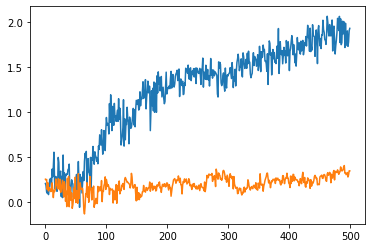

In [13]:
plt.plot(train_rewards)
plt.plot(test_rewards)

# plot does pretty well, much better on train set since that's what agent learned on
# randomness --> different result each time
# Q learning beats buy and hold on test set generally
# agent learn, variability goes down --> good thing, not random luck